<a href="https://colab.research.google.com/github/ddeweerd/Colab/blob/main/Lab4B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the second part of this lab session, we'll delve into the practical applications of deep learning, specifically autoencoders. You'll have the opportunity to construct a small standard autoencoder, focusing on 48 genes from the Th17 cell differentiation pathway. Additionally, we'll explore a pre-trained VAE for RNA-seq data. With this model we will impute missing data and generate new samples. The complete lab will be in R and made available as a google colaboratory notebook. This also means that your created files will be deleted after you close the session. For this part of the lab, an R package is created containing the functionality and data that we will use. So the first order of business is to install this package, like this:

In [106]:
devtools::install_github("ddeweerd/VAEanalysis", force=TRUE)


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpFrSy2O/remotes4e837a25930/ddeweerd-VAEanalysis-9c55122/DESCRIPTION’ ... OK
* preparing ‘VAEanalysis’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘VAEanalysis_0.1.0.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Then the package and other packages can be loaded:

In [54]:
library(VAEanalysis)
library(keras)
library(dplyr)
library(ggplot2)

Now we can build an autoencoder using the function *build_autoencoder()*. The function builds a basic feed-forward densely connected autoencoder with an input layer, three intermediate layers and an output layer. The default parameters are an input layer of 48 units, one for each gene in the training dataset, 24 nodes for the first intermediate layer, 12 nodes for the middle layer, and 24 nodes for the last layer before the output. If the function is called without any arguments, the default is used. The returned autoencoder is already *compiled* (ready for training) and the loss function is Mean Squared Error (MSE).

In [55]:
autoencoder <- build_autoencoder()

Calling the *summary()* function gives an overview of our new autoencoder model

In [72]:
summary(autoencoder)

Model: "model_5"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 input_1 (InputLayer)               [(None, 48)]                    0           
 model_3 (Functional)               (None, 12)                      1476        
 model_4 (Functional)               (None, 48)                      1512        
Total params: 2988 (11.67 KB)
Trainable params: 2988 (11.67 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


Please observe that three layers will appear: input_1, model_x, and model_y. The specific names for x and y can vary based on how often you've used the build_autoencoder() function. This structure arises because the autoencoder is constructed using two separate models: the encoder and the decoder. The number of trainable parameters is 2988

**Training the Autoencoder:**

With our autoencoder now set up, the next step is to train it. The essence of training is to feed the model with data, allow it to make predictions, and then adjust the weights based on the discrepancies between the predicted and actual outputs.

**Utilizing the Training Data:**

As mentioned before, there is training data included in the package, accessible with TH17_train. This dataset contains the RNA-seq gene expressions in log(x+1) that our autoencoder can learn from.

**Steps for Training:**

**1. Data Loading:**

Begin by extracting the TH17_train data from the package.

In [56]:
TH17_train <- TH17_train

**2. Model Training:**

Start the training process using the fit function.

In [57]:
history <- autoencoder %>% fit(
  TH17_train, TH17_train,
  epochs = 500,
  batch_size = 256,
  shuffle = TRUE,
  validation_split = 0.2
)


 * *epochs* indicates the number of times the entire dataset is passed forward and backward through the autoencoder.
 *   *batch_size* represents the number of training examples used in one iteration.
 *   *validation_split* reserves a fraction of the training data to validate the model's performance in each epoch.

**3. Tracking Progress:**

The training process will continually fine-tune the weights of the model. The outcomes of each epoch, which include metrics like loss and validation loss, are captured within the history variable. This variable can later be used to visualize and assess the training performance.

**Visualizing the Training Progress:**

After training the autoencoder, we can assess how well the model learned from the data. One way to gauge this is by visualizing the changes in the model's loss and validation loss over each epoch. This provides insights into the model's learning trajectory, helping to identify potential issues like overfitting or if more training might be beneficial.

The *history* object contains this information and it a visual plot can be obtained by just calling the *plot()* function on it:

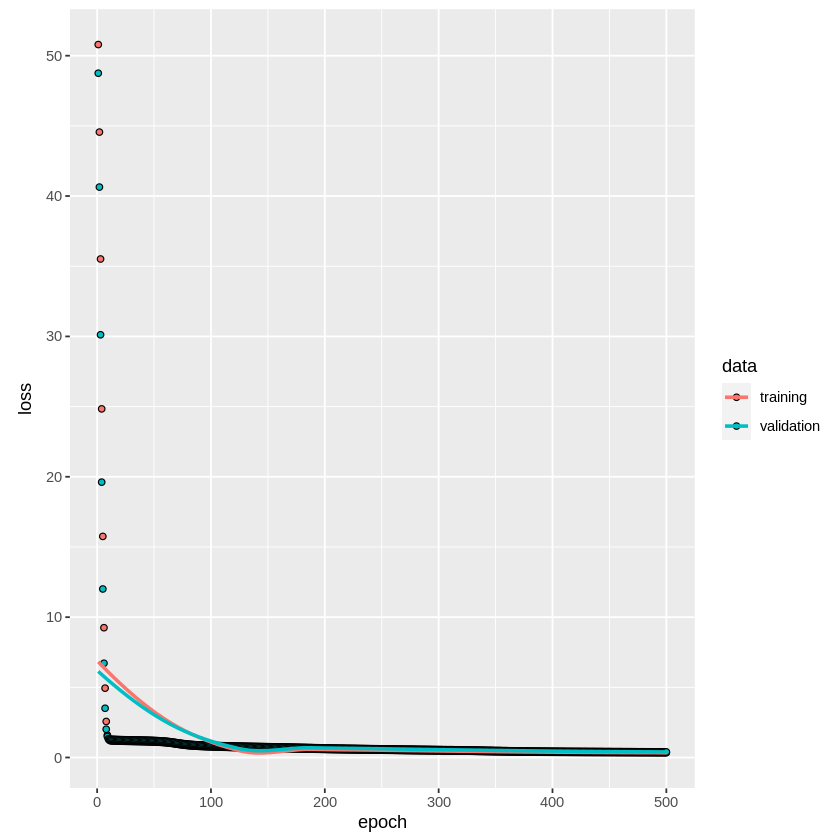

In [58]:
plot(history)

The first few epochs distort the plot due to the large initial loss value, so it is more informative to exclude those initial epochs from the visualization to get a clearer view of the subsequent training progress. To this end, a function called *slice_history()* has been included in the package. It takes two arguments, the first being the history object and the second how many iterations to keep, counted from the last one.



In [59]:
history <- slice_history(history, 100)

In this example, we kept the last 100 epochs. Redoing the plot gives:

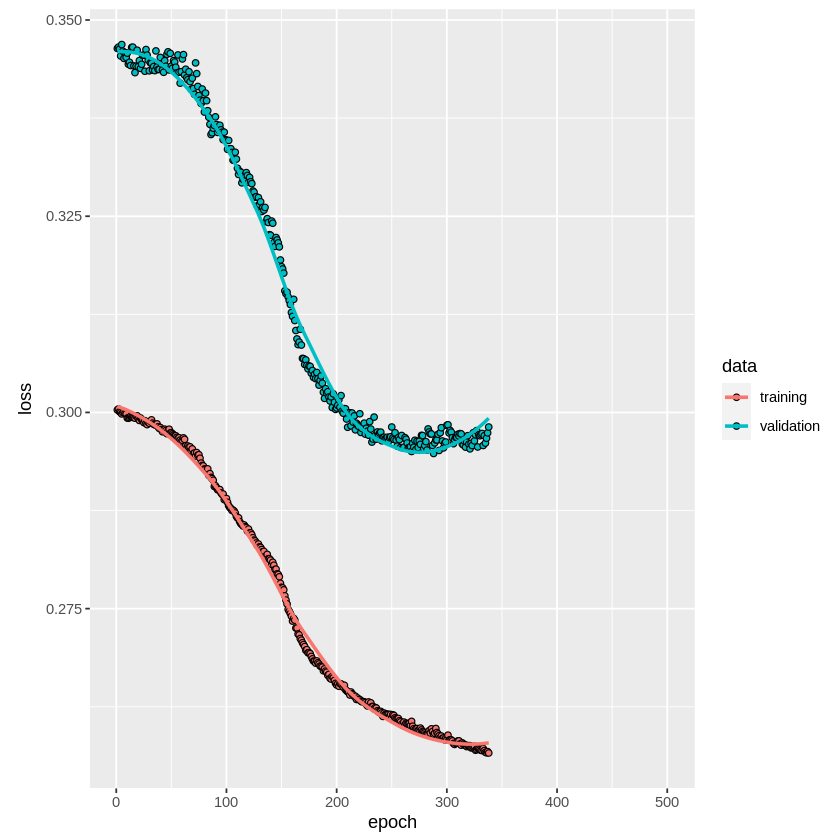

In [66]:
plot(history)

One common challenge when training deep learning models is determining the optimal number of epochs. Training for too few epochs may leave the model underfit, while too many epochs can lead to overfitting. A common strategy to deal with this issue is to employ "Early Stopping".

Early stopping is a technique where the training process is automatically halted once the model's performance on a validation set stops improving. This ensures that the model doesn't overfit the training data.

**Implementing Early Stopping in R Keras:**

The callback will monitor the validation loss during training. If the validation loss doesn't improve (decrease) for a specified number of consecutive epochs (defined by the patience parameter), the training will be stopped.

In [64]:
early_stop <- callback_early_stopping(monitor = "val_loss", patience = 50)


In this example, we stop the training if the validation loss has not decreased in 10 epochs.

To add this callback to the training, we include it in the *fit()* function, like this:

In [65]:
history <- autoencoder %>% fit(TH17_train, TH17_train,
                               epochs = 500,
                               batch_size = 256,
                               validation_split = 0.2,
                               callbacks = list(early_stop))


Implement early stopping in your model training process and observe when the training stops. Analyze the history object to see how the training and validation loss progressed, report the approximate validation loss when the training stopped plot the history object.

 A crucial aspect of deep learning is ensuring that models generalize well to new, unseen data. It's not enough for a model to perform well on its training data; it must also be capable of making accurate predictions on data it hasn't been exposed to during training.

 The first thing we do is extracting the test data from the package:

In [ ]:
TH17_test <- TH17_test

Use the predict function to obtain the model's output on the test data. For an autoencoder, the goal is to reconstruct the input, so the output will be a reconstructed version of the test data.

In [12]:
reconstructed_TH17 <- autoencoder %>% predict(TH17_test)

Now we can analyze how well the autoencoder reconstructed the unseen samples. We could, for example, calculate the reconstruction error or visualize original vs. reconstructed data.



In [67]:
mse <- mean((TH17_test - reconstructed_TH17)^2)
print(paste("Mean Squared Error on Test Data:", mse))

[1] "Mean Squared Error on Test Data: 0.244166522708719"


We could visualize the original vs the reconstructed data in a scatterplot. ggplot2 offers nicer visualizations, but it requires us to wrangle the data in a data.frame, and we can do so by converting the matrices of values to two vectors and putting them in a data.frame:

In [70]:
original_vector <- as.vector(TH17_test)
reconstructed_vector <- as.vector(reconstructed_TH17)

comparison_df <- data.frame(Original = original_vector, Reconstructed = reconstructed_vector)


Now we can use ggplot2 to make a scatterplot comparing the original and reconstructed values. A perfect reconstruction would result in all points lying on the line y = x:

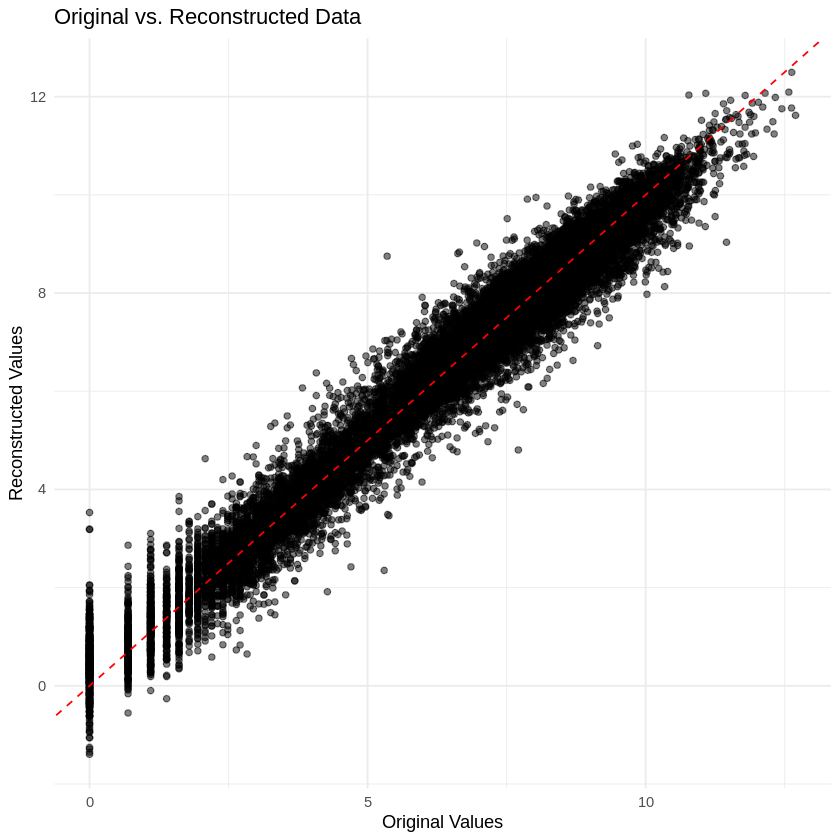

In [71]:

ggplot(comparison_df, aes(x = Original, y = Reconstructed)) +
  geom_point(alpha = 0.5) +
  geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +
  labs(title = "Original vs. Reconstructed Data",
       x = "Original Values",
       y = "Reconstructed Values") +
  theme_minimal()


After exploring the capabilities of a basic autoencoder on a subset of genes, we will now delve deeper into the world of deep generative models, specifically, the Variational Autoencoder (VAE). Unlike regular autoencoders, VAEs can generate new samples that are similar to the input data. Our focus will be on a pre-trained VAE that has been trained on an RNA-seq gene expression dataset encompassing 16,819 genes.

In order to load the model, first we need to import two python scripts that are included in the package, like this:

In [107]:
VAE_builder <- reticulate::import_from_path(module = "VAE_builder", path = system.file(package = "VAEanalysis"))
utils_VAE <- reticulate::import_from_path(module = "utils_VAE", path = system.file(package = "VAEanalysis"))

After that, we can load the VAE. We also load the encoder and decoder model seperately.

In [108]:
encoder <- keras::load_model_hdf5(system.file("extdata", "encoder.h5", package = "VAEanalysis"))
decoder <- keras::load_model_hdf5(system.file("extdata", "decoder.h5", package = "VAEanalysis"))
VAE <- keras::load_model_hdf5(system.file("extdata", "VAE.h5", package = "VAEanalysis"))


One of the powerful capabilities of autoencoder is their ability to handle and impute missing data. Next, we will explore how the pre-trained VAE model can be utilized to fill in missing gene expression values, allowing for more complete and accurate analyses. Autoencoders can learn the underlying distribution of the data and when faced with missing data, a VAE can generate a probable value based on what it has learned from the complete dataset.

The package comes with 10 test samples in a matrix under the variable name *full_profiles*. Let's go ahead and load them:

In [109]:
full_profiles <- full_profiles

The matrix has 10 rows (samples) and 16819 columns (genes).

In [87]:
dim(full_profiles)

[1]    10 16819

Also included is a vector of genenames in the right order of the data. We can use this vector to, for example, localize TP53:

In [23]:
which(genenames == "TP53")

[1] 12889

This means that TP53 is in column 12889. By setting its value to 0, we're essentially simulating a missing data point. Let's then run these samples through the VAE to infer and impute this "missing" value.

First, let's make a copy of the data so we retain the original values

In [78]:
changed_profiles <- full_profiles

Subsequently, set column 12889 to 0:

In [79]:
changed_profiles[,12889] <- 0

Finally, run through the VAE:

In [33]:
reconstructed_profiles <- VAE %>% predict(changed_profiles)

Since we artificially created the missing values, we can check how close the model's estimate is to reality. One of the ways we can do that is again with a plot. First, let's extract the imputed values for TP53:

In [88]:
tp53_imputed_value <- reconstructed_profiles[,12889]

Next, extract the original TP53 values and wrangle it in a format ggplot2 can handle, a data.frame:

In [90]:
tp53_original_value <- full_profiles[,12889]
comparison <- data.frame(Original = tp53_original_value, Imputed = tp53_imputed_value)


Now we plot the original and imputed values side by side for a visual comparison.

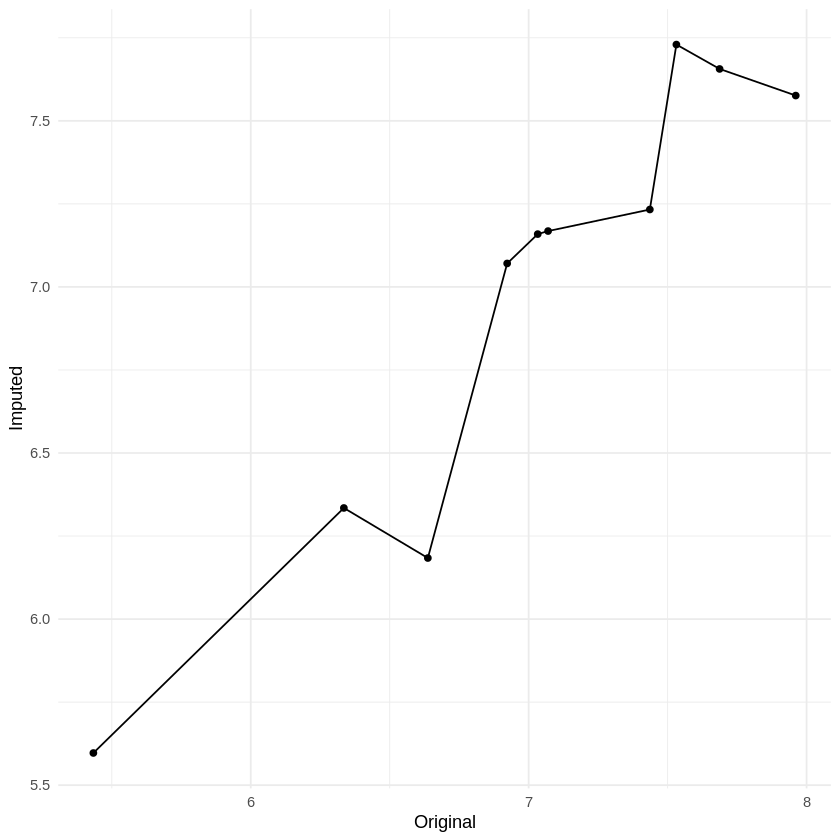

In [91]:
library(ggplot2)
ggplot(comparison, aes(x = Original, y = Imputed)) +
  geom_point() +
  geom_line(aes(group = 1)) +
  theme_minimal()


The true power of Variational Autoencoders (VAEs) extends beyond just imputation. VAEs are generative models, meaning they can produce new samples that are similar to the input data they were trained on. In this section, we will harness this capability to generate new, synthetic gene expression profiles.

At a high level, generative models like VAEs learn to capture the probability distribution of the training data. This means they can generate new samples that are statistically similar to the input data.

The VAE encodes input data into a 'latent space'. By sampling points from this space, we can decode them back into the original data space, resulting in new samples.

In [110]:
output <- extract_mu_log_var(VAE, full_profiles)

mu_values <- output$mu
log_var_values <- output$log_var


In [111]:
generated_samples <- generate_data(decoder, mu_values, log_var_values)


Decode

check for example TP53